In [1]:
import os, re
import numpy as np

In [2]:
# change to the root folder
base_dir = "/Users/jibanmac/Documents/GitHub/gpy_dla_detection/"
os.chdir(base_dir)

try:
    assert "null_gp.py" in os.listdir("gpy_dla_detection")
except Exception as e:
    print(e)
    print("[Warning] Change the directory of base_dir to the path of your gpy_dla_detection repository.")

In [3]:
# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi']= 150

# Tutorial: Automating Lyman Alpha Absorption Detection with Gaussian Processes

author: Ming-Feng Ho (jibancat)


In this tutorial, we'll show you how to automate the detection of (strong) Lyman alpha absorbers (log NHI = 17 - 23) in quasar spectra using Gaussian processes. This approach offers a powerful and flexible tool for modeling complex datasets and identifying subtle features within them.

Throughout the tutorial, we'll follow a step-by-step approach that will help you get up to speed with using Gaussian processes for Lyman alpha absorption detection. Here's a brief overview of what we'll cover:

1. Understanding Quasar Spectrum Data: Before we dive into the specifics of Gaussian processes, it's important to have a solid understanding of the data we'll be working with. We'll explain what quasar spectra are, what information they contain, and how to visualize them using Python.
2. Understanding Voigt Profiles: To model Lyman alpha absorbers, we'll use Voigt profiles, which describe the way that light is absorbed by gas clouds in space. We'll introduce the mathematics behind Voigt profiles and explain how they're used in absorption analyses.
3. Using Bayesian Model Selection: Finally, we'll show you how to use Bayesian model selection to identify the best-fit model for the absorption features in quasar spectra. This technique allows us to compare different models and choose the one that best explains the data.

By the end of this tutorial, you'll have a solid understanding of how to use Gaussian processes to automate Lyman alpha absorption detection in quasar spectra. Let's get started!





### Different types of Lyman alpha absorbers

| Types | Column density | 
| ---   | ---            |
| Damped Lyman alpha absorber (DLA) | $\geq 10^{20.3} \mathrm{cm}^{-2}$ |
| Super Lyman limit system (SLLS)   | $10^{19} \sim 10^{20.3} \mathrm{cm}^{-2}$ |
| Lyman limit system (LLS)          | $10^{17} \sim 10^{19} \mathrm{cm}^{-2}$ |


## Understand Quasar Spectrum Data

Quasar spectra provide a wealth of information about the properties of these distant objects. At its core, a spectrum is simply a record of the amount of light received from the quasar at each wavelength.

In this tutorial, we'll use Python to download a sample spectrum from the Sloan Digital Sky Survey (SDSS) website and plot it using the popular Matplotlib library. We'll show you how to read in the data, manipulate it to extract the relevant information, and create a visual representation of the spectrum.



In [4]:
# The test selection file includes a list of 100 quasar spectra and their redshifts
from tests import test_selection
# The module to read spectrum, which also helps us to download the file (for SDSS DR12 spectrum)
from gpy_dla_detection.read_spec import read_spec, retrieve_raw_spec

In [5]:
# take a spectrum and download it
nspec = 51 # I picked a spectrum with an obvious DLA detection
filename = test_selection.filenames[nspec]
z_qso    = test_selection.z_qsos[nspec]

# If we haven't downloaded the file, this cell will help you download the file from SDSS database
if not os.path.exists(filename):
    # This line gets the plate, mjd, and fiber_id from the given filename
    # Note: re is the regex.
    plate, mjd, fiber_id = re.findall(
        r"spec-([0-9]+)-([0-9]+)-([0-9]+).fits", filename,
    )[0]
    # Download the file using the given plate, mjd, and fiber_id
    retrieve_raw_spec(int(plate), int(mjd), int(fiber_id))

# make sure the file exists
assert os.path.exists(filename) == True

In [6]:
# Read the raw spectrum: This line reads the spectrum file into four numpy arrays
wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)

In order to work with the quasar spectrum data, it's important to understand the various components that make up each dataset. Here's a quick rundown of the key arrays you'll be working with:

* `wavelengths`: This 1D float array contains the observer-frame wavelengths of the quasar spectrum. These wavelengths are measured in units of Angstroms and provide the x-axis for any plots or analyses.
* `flux`: This 1D float array contains the flux (photons per wavelength bin) of the quasar spectrum. It represents the y-axis of any plots or analyses and contains the information about the quasar's emission and absorption features.
* `noise_variance`: This 1D float array contains the instrumental noise variance of the flux. It provides an estimate of the uncertainty in the flux measurements and is used to propagate errors through any subsequent analyses.
* `pixel_mask`: This 1D boolean array contains a mask provided by SDSS, which should be used to mask out undesired regions of the spectrum. This may include regions where the signal-to-noise ratio is low or where there are known artifacts or contaminants.

By understanding these key components of the quasar spectrum data, you'll be able to effectively analyze and visualize the data using a variety of techniques.





Text(0, 0.5, 'Flux')

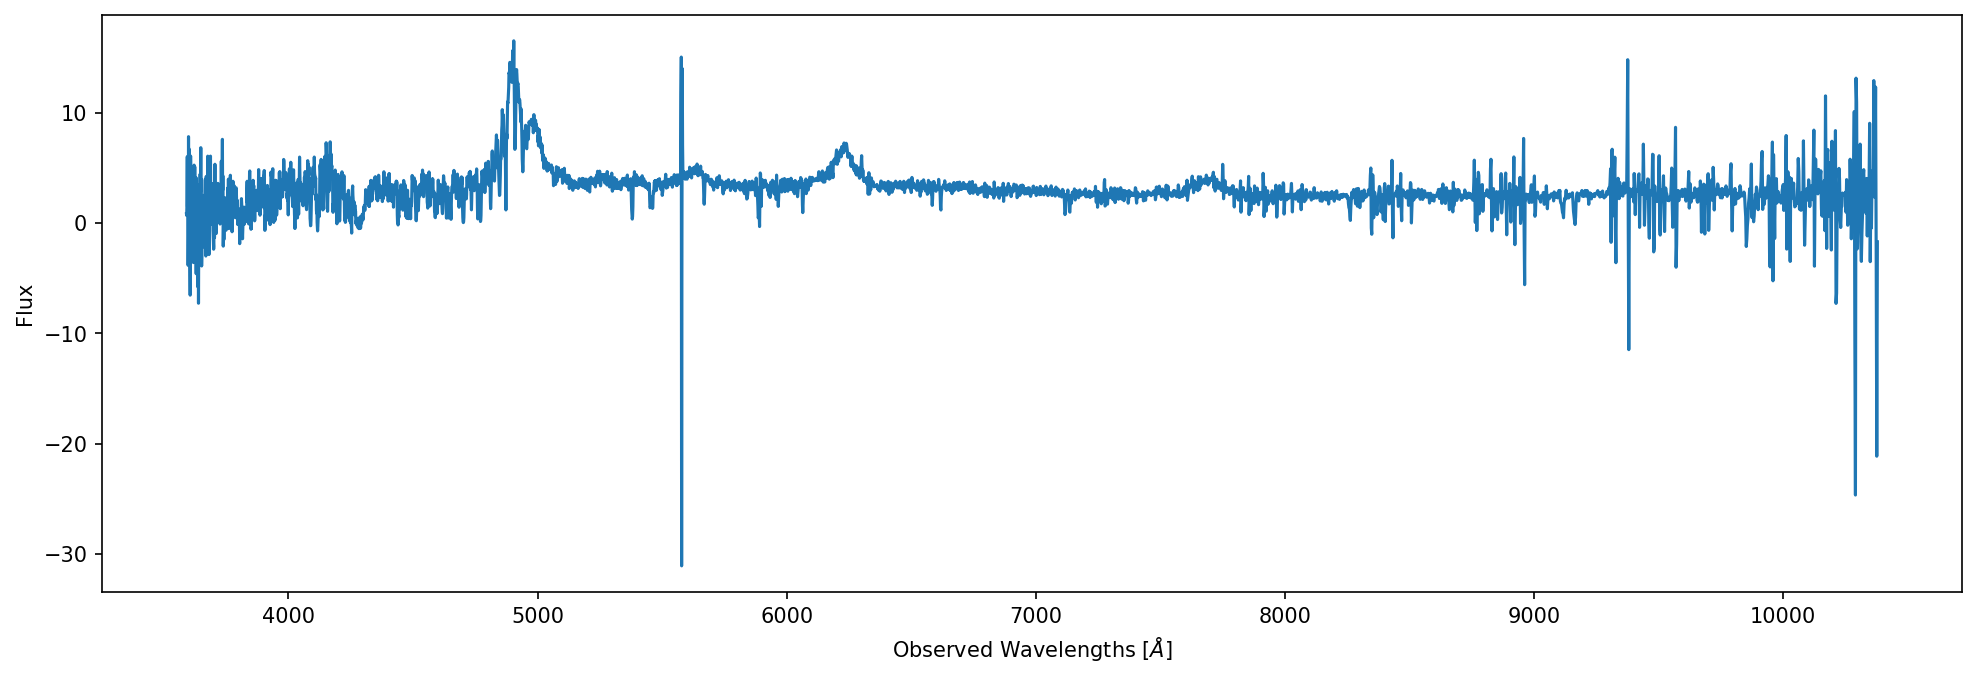

In [7]:
# plot it in "observed wavelengths"
plt.figure(figsize=(16, 5))
plt.plot(wavelengths, flux)
plt.xlabel("Observed Wavelengths [$\AA$]")
plt.ylabel("Flux")

It's important to note that the wavelengths we observe from distant quasars are redshifted due to the expansion of the Universe. This means that the observed wavelengths are stretched relative to the original wavelengths emitted by the quasar. In order to account for this effect, we need to convert the observed wavelengths to their corresponding rest-frame wavelengths.

The conversion from observed wavelengths to rest-frame wavelengths is given by the relation:

$$
\lambda_\mathrm{rest} = \lambda_\mathrm{obs} / (1 + z)
$$

where $z$ is the redshift of the quasar. The redshift tells us how much the Universe has expanded between the time the light was emitted by the quasar and the time it was observed by us.

By shifting the observed wavelengths to their corresponding rest-frame wavelengths, we can analyze the quasar spectrum as if it were observed in the lab on Earth, without the effects of redshift. This is a standard procedure in quasar spectrum analysis and is an essential step in understanding the properties of these distant objects.

We can also express the redshift effect in terms of the scale factor of the Universe. The conversion from observed wavelengths to rest-frame wavelengths can be written as:

$$
\lambda_\mathrm{obs} = \lambda_\mathrm{rest} \times \frac{1}{a}
$$

Here, $a$ is the scale factor of the Universe, which describes the relative size of the Universe at different times. At the present time, $a=1$, so the observed wavelengths are the same as the rest wavelengths. The rest wavelengths, $\lambda_\mathrm{rest}$, refer to the wavelengths that would be observed if the quasar were at rest relative to us.

The scale factor $a$ is related to the redshift $z$ by:

$$
a = \frac{1}{1+z}
$$

As the Universe expands and the quasar recedes from us, the observed wavelengths are stretched, leading to a larger value of $z$ and a smaller value of $a$.


Text(0, 0.5, 'Flux')

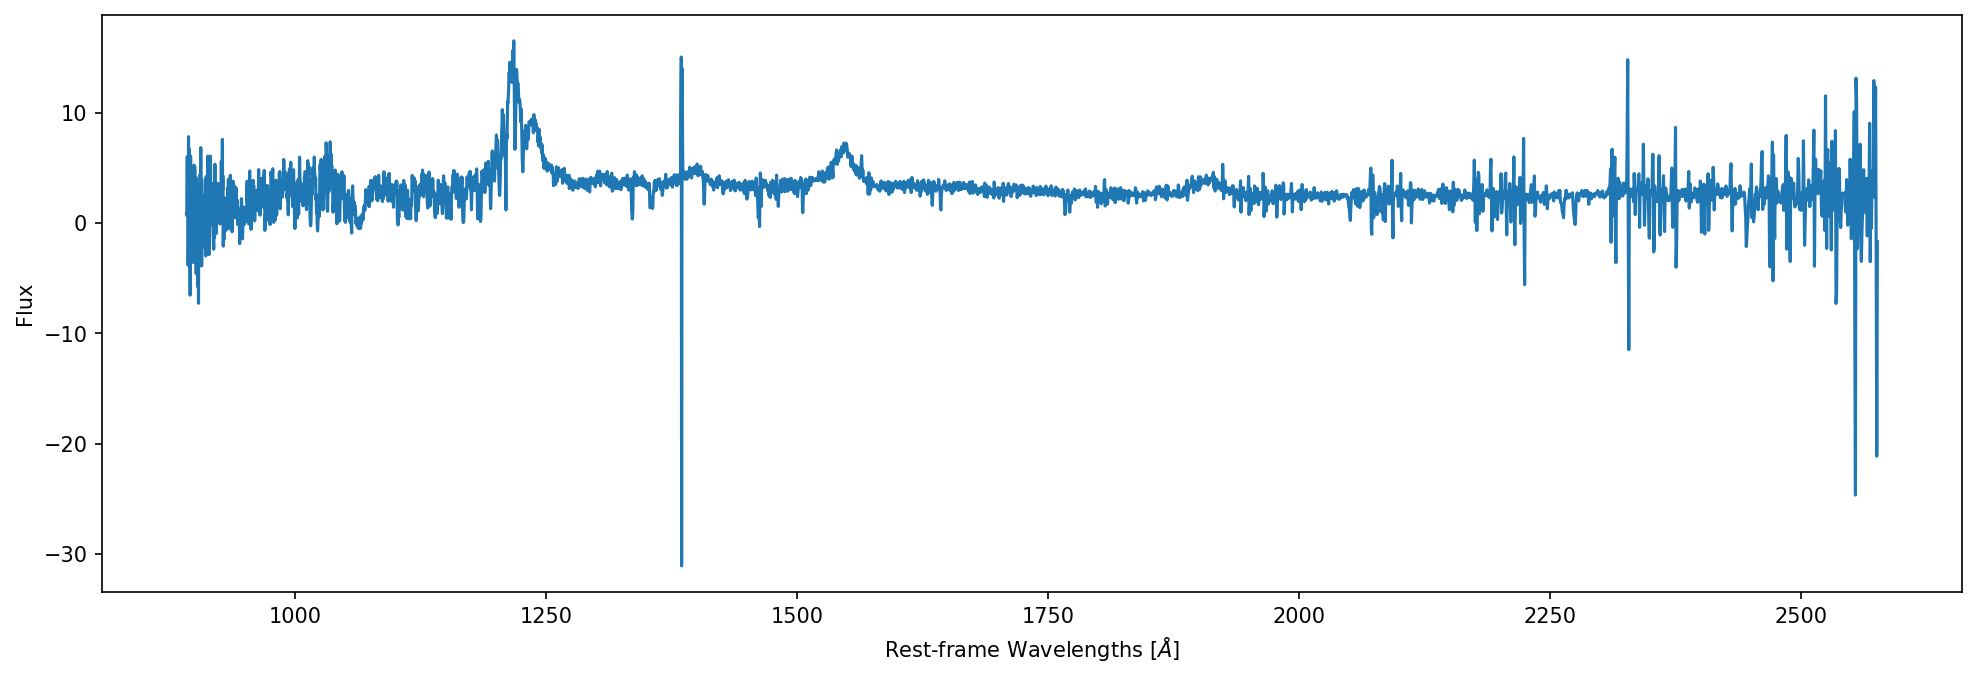

In [8]:
# plot it in "observed wavelengths"
rest_wavelengths = wavelengths / (1 + z_qso)

plt.figure(figsize=(16, 5))
plt.plot(rest_wavelengths, flux)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Flux")

After converting the observed wavelengths to rest-frame wavelengths, the x-axis of the plot now represents the wavelengths we would see if there were no expansion of the Universe, i.e., the wavelengths that a person at the rest-frame of the quasar would observe.

The blue line in the plot represents a real quasar observation obtained from the Sloan Digital Sky Survey. The line appears to be very wiggly because of the uncertainty associated with each flux pixel in the spectrum. The uncertainty arises due to various reasons such as insufficient exposure time, instrumental limitations, and unknown sources.

As quasar spectra often contain several emission lines, we can identify these lines using their rest-wavelength values. Some examples of emission lines commonly observed in quasar spectra and their corresponding rest-wavelength values are shown in the table below:


| Rest-Wavelength | Emission Line |
| --- | --- |
| 1215.24 | $Ly\alpha$ (Lyman Alpha) |
| 1549.48 | CIV (Carbon Four)  |
| 2799.117 | MgII (Magnesium Two) |

See the detailed table in [here](https://classic.sdss.org/dr6/algorithms/linestable.html).

Let's label those lines in the spectrum:


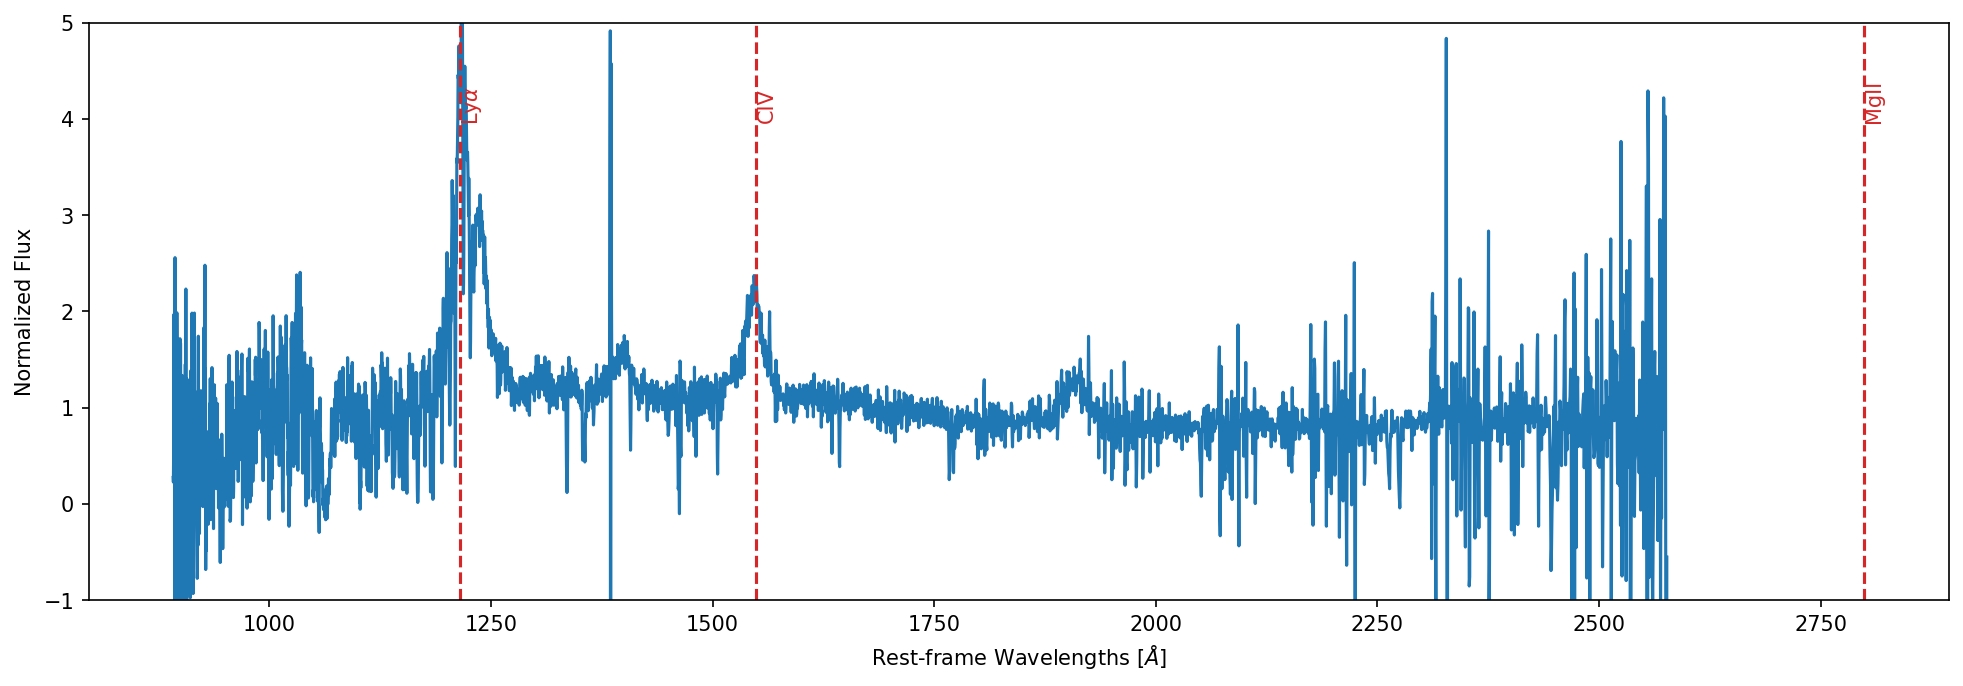

In [9]:
# Names and Rest-Wavelengths of the Emission Lines
emission_rest_wavelengths = [1215.24, 1549.48, 2799.117]
emission_names = [r"Ly$\alpha$", r"CIV", r"MgII"]

plt.figure(figsize=(16, 5))
# I did a normalization in this step to make the plot esier to see
plt.plot(rest_wavelengths, flux / np.mean(flux))
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-1, 5)

# plot the emission lines to help measure the z
for n, w in zip(emission_names, emission_rest_wavelengths):
    plt.vlines(w, -1, 5, color="C3", ls="--")
    plt.text(w, 4, n, rotation="vertical", color="C3")


For Lyman alpha absorptions, these absorptions will be in the rest-frame wavelengths $< 1216 \AA$:

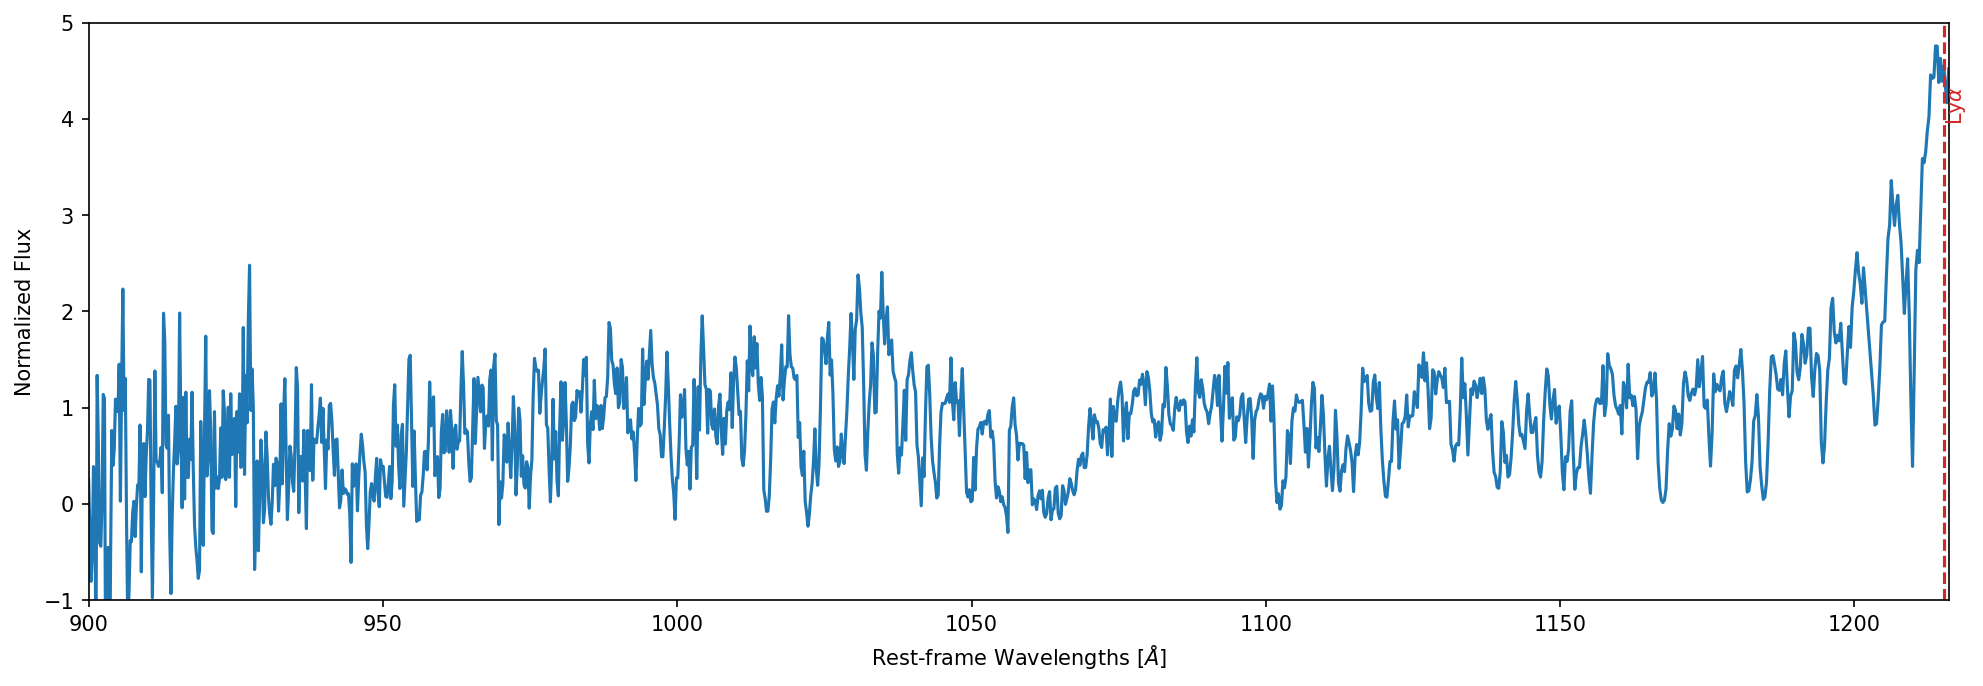

In [10]:
# Names and Rest-Wavelengths of the Emission Lines
emission_rest_wavelengths = [1215.24]
emission_names = [r"Ly$\alpha$"]

plt.figure(figsize=(16, 5))
plt.plot(rest_wavelengths, flux / np.mean(flux))
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-1 ,5)
plt.xlim(900, 1216)

# plot the emission lines to help measure the z
for n, w in zip(emission_names, emission_rest_wavelengths):
    plt.vlines(w, -1, 5, color="C3", ls="--")
    plt.text(w, 4, n, rotation="vertical", color="C3")


## Understand Voigt Profile

Voigt profile is a standard profile used by astronomers to model the absorption systems:
$$
\begin{equation}
   \begin{split}
      \phi(v, b, \gamma)
      &=\\
      \int \frac{d v}{\sqrt{2\pi}\sigma_v} &\exp{(-v^2 / 2\sigma_v^2)}
      \frac{4 \gamma_{\ell u}}{16 \pi^2 [ \nu - (1 - v/c)\nu_{\ell u} ]^2 + \gamma_{\ell u}^2},
   \end{split}
\end{equation}
$$
which is a convolution between a Lorenztian line profile and a Gaussian line profile. The $\sigma_v$ is the one-dimensional velocity dispersion, $\gamma_{\ell u}$ is a parameter for Lorenztian profile, $\nu$ is the frequency, and $u$ represents the upper energy level and $\ell$ represents the lower energy level.

Both profiles are parameterised by the relative velocity $v$, which means both profiles are distributions in the 1-dimensional velocity space:
$$
\begin{equation}
   v = c \left( \frac{\lambda}{\lambda_{1u}} \frac{1}{(1 + z_\mathrm{absorber})} -1 \right).
\end{equation}
$$
The standard deviation of the Gaussian line profile is related to the broadening parameter $b = \sqrt{2} \sigma_v$, and if we assume the broadening is entirely due to thermal motion:
$$
\begin{equation}
   b = \sqrt{ \frac{2 k T}{m_p} }.
\end{equation}
$$
Introducing the damping constant $\Gamma  = 6.265 \times 10^8 \textrm{s}^{-1}$ for Lyman alpha, we have the parameter $\gamma_{\ell u}$ to describe the width of the Lorenztian profile
$$
\begin{equation}
   \gamma_{\ell u} = \frac{\Gamma \lambda_{\ell u}}{4\pi}.
\end{equation}
$$

We will use the `voigt.py`, which is a Voigt profile we've written for Lyman alpha absorptions, to demonstrate the voigt profile.

In [11]:
from gpy_dla_detection import voigt

* `wavelengths` (np.ndarray) : Array of observed wavelengths (in Ångstroms)
* `nhi` (float) : Column density of the absorber (in cm⁻²)
* `z_dla` (float) : Redshift of the absorber (dimensionless)
* `num_lines` (int) : Number of Lyman series lines used in the absorber (maximum 31)
* `broadening` (boolean) : Whether to apply Gaussian broadening to the observed spectrum


(900.0, 1216.0)

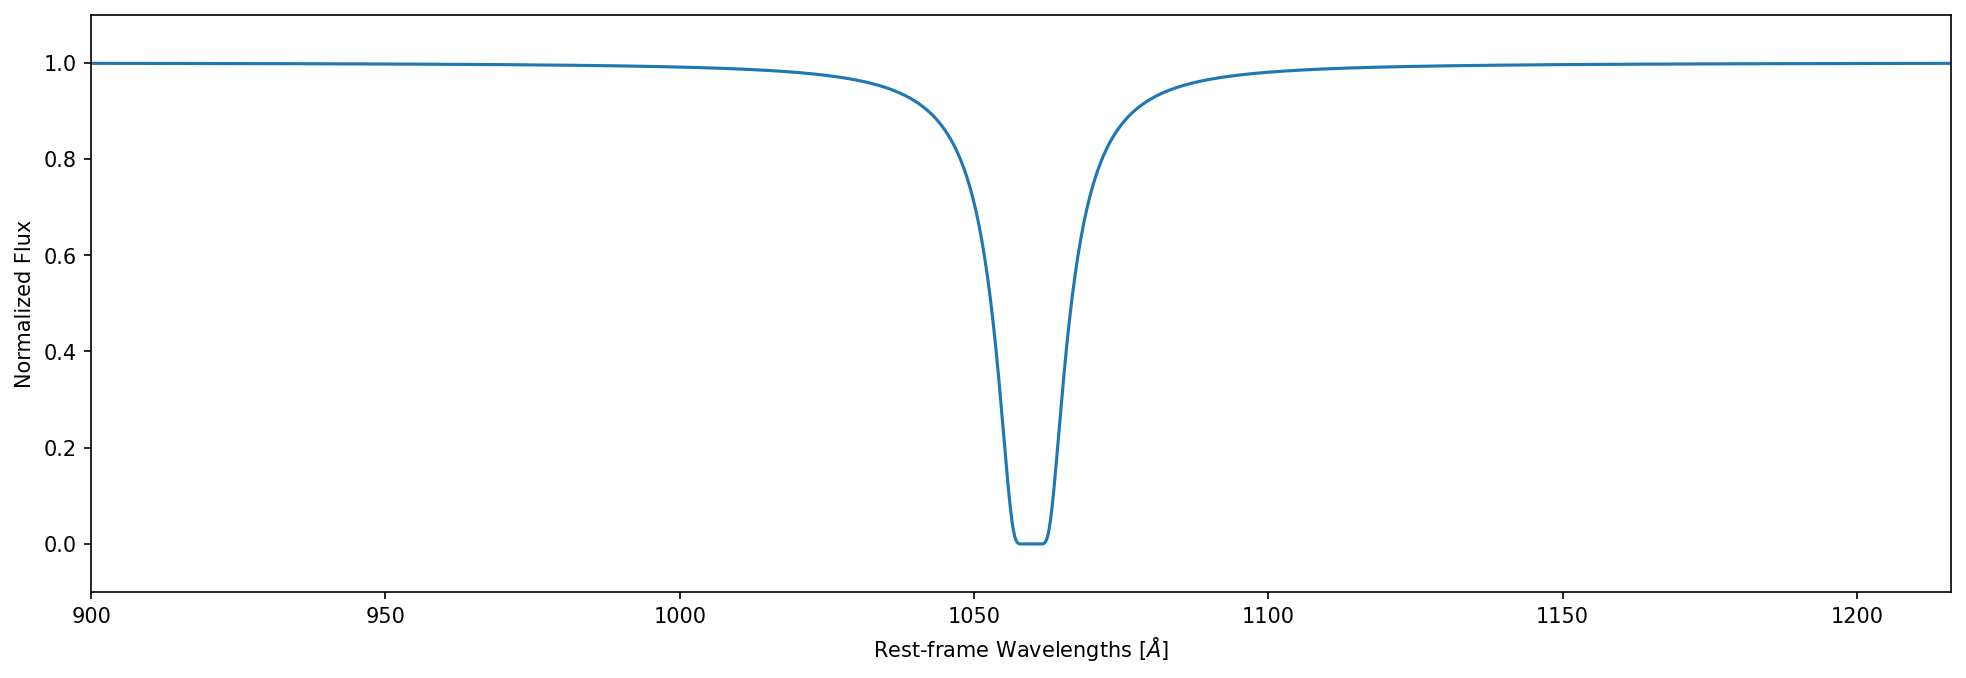

In [12]:
# Assume there's an absorber at redshift 2.511
z_dla = 2.511
nhi   = 10**21 # [cm^-2]

voigt_profile = voigt.voigt_absorption(
    wavelengths,
    nhi=nhi,
    z_dla=z_dla,
    num_lines=1,
    broadening=False,
)

plt.figure(figsize=(16, 5))
plt.plot(rest_wavelengths, voigt_profile)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-0.1 , 1.1)
plt.xlim(900, 1216)

Thes profile is considered saturated when a portion of it reaches a flux value of 0, indicating that the neutral hydrogen has completely absorbed the photons. The central part of the profile appears Gaussian, while the outer regions are characterized by Lorentzian wings. When the column density (`nhi`) is small, the profile looks more like a Gaussian distribution.

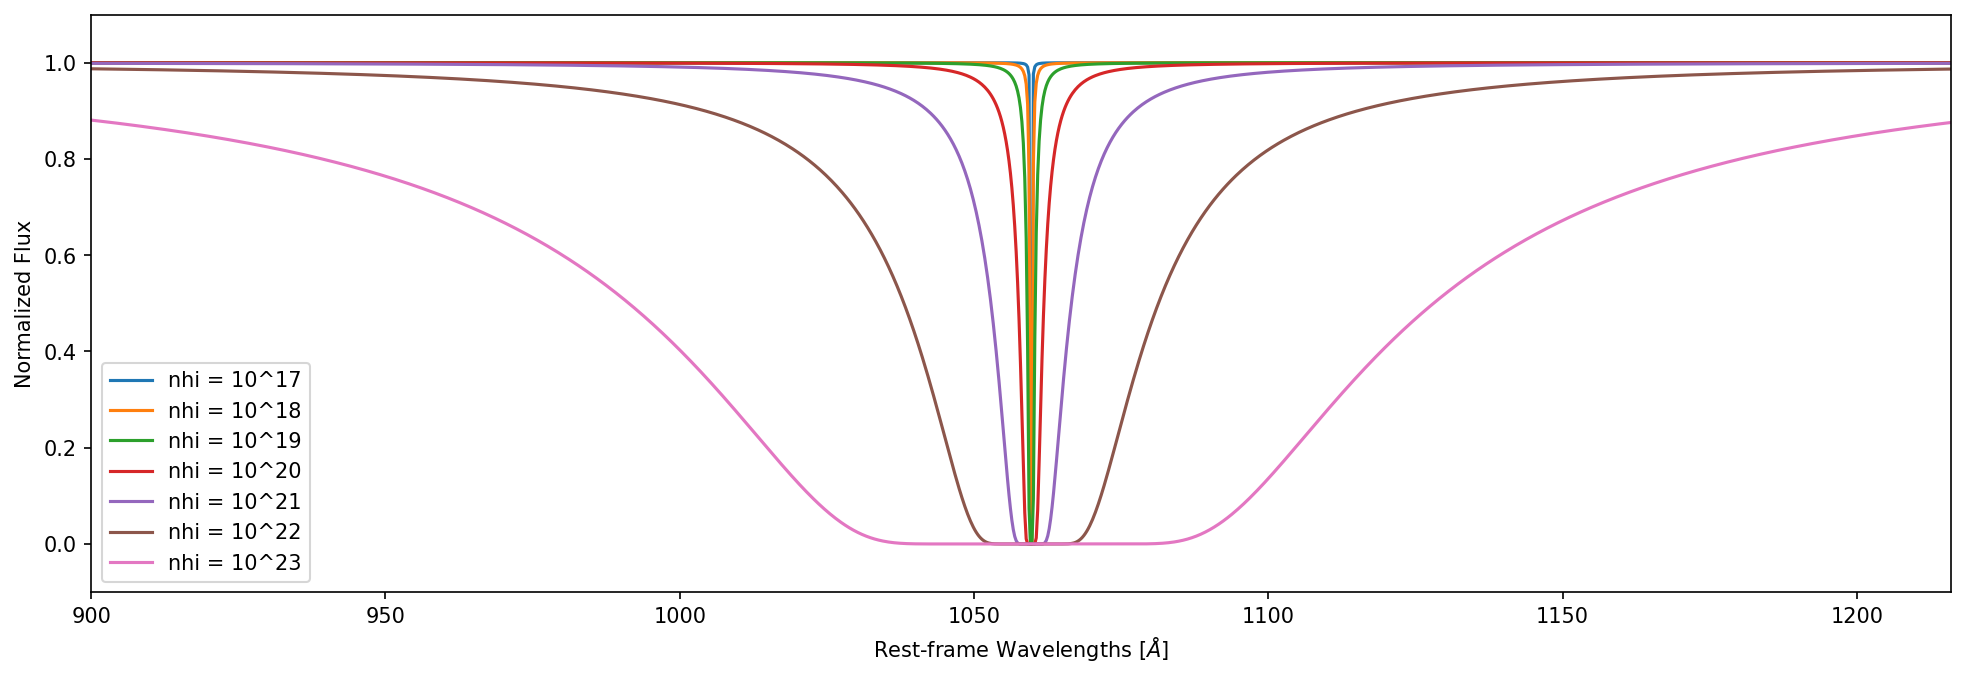

In [13]:
# Assume there's an absorber at redshift 2.511
z_dla = 2.511

list_nhis = [17, 18, 19, 20, 21, 22, 23] # [cm^-2]

plt.figure(figsize=(16, 5))

for nhi in list_nhis:
    voigt_profile = voigt.voigt_absorption(
        wavelengths,
        nhi=10**nhi,
        z_dla=z_dla,
        num_lines=1,
        broadening=False,
    )

    plt.plot(
        rest_wavelengths, voigt_profile,
        label="nhi = 10^{}".format(nhi),
    )

plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-0.1 , 1.1)
plt.xlim(900, 1216)
plt.legend()

The Lyman alpha line represents the transition of a hydrogen atom from its ground state to the first excited state. By increasing the `num_lines` parameter, we can also include higher order transitions, such as Lyman beta (ground state to second excited state) and Lyman gamma (ground state to third excited state).

(850.0, 1216.0)

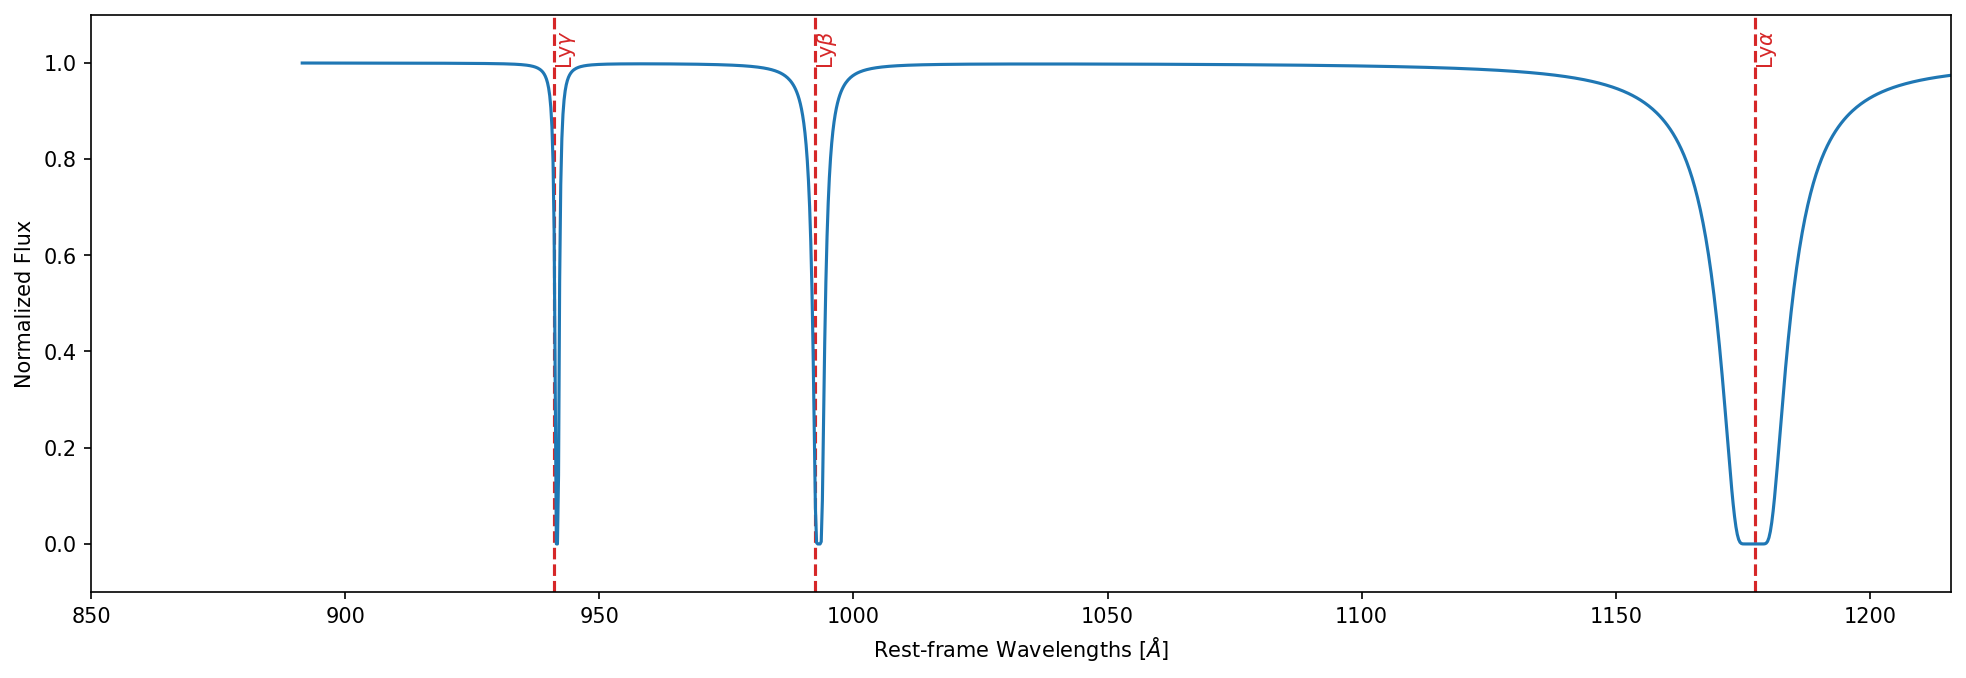

In [14]:
# Assume there's an absorber at redshift 2.9
z_dla = 2.9
nhi   = 10**21 # [cm^-2]

plt.figure(figsize=(16, 5))

voigt_profile = voigt.voigt_absorption(
    wavelengths,
    nhi=nhi,
    z_dla=z_dla,
    num_lines=3,
    broadening=False,
)

plt.vlines(1216 * (1 + z_dla) / (1 + z_qso), -0.1, 1.1, color="C3", ls="--", label=r"Ly$\alpha$")
plt.vlines(1025 * (1 + z_dla) / (1 + z_qso), -0.1, 1.1, color="C3", ls="--", label=r"Ly$\beta$")
plt.vlines(972 * (1 + z_dla) / (1 + z_qso), -0.1, 1.1, color="C3", ls="--", label=r"Ly$\gamma$")
plt.text(1216 * (1 + z_dla) / (1 + z_qso), 1, r"Ly$\alpha$", rotation="vertical", color="C3")
plt.text(1025 * (1 + z_dla) / (1 + z_qso), 1, r"Ly$\beta$", rotation="vertical", color="C3")
plt.text(972 * (1 + z_dla) / (1 + z_qso), 1, r"Ly$\gamma$", rotation="vertical", color="C3")

plt.plot(rest_wavelengths, voigt_profile)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-0.1 , 1.1)
plt.xlim(850, 1216)


If we have 31 Lyman series lines and we lower down the column density to $10^{18}$ [cm^-2]:

(850.0, 1216.0)

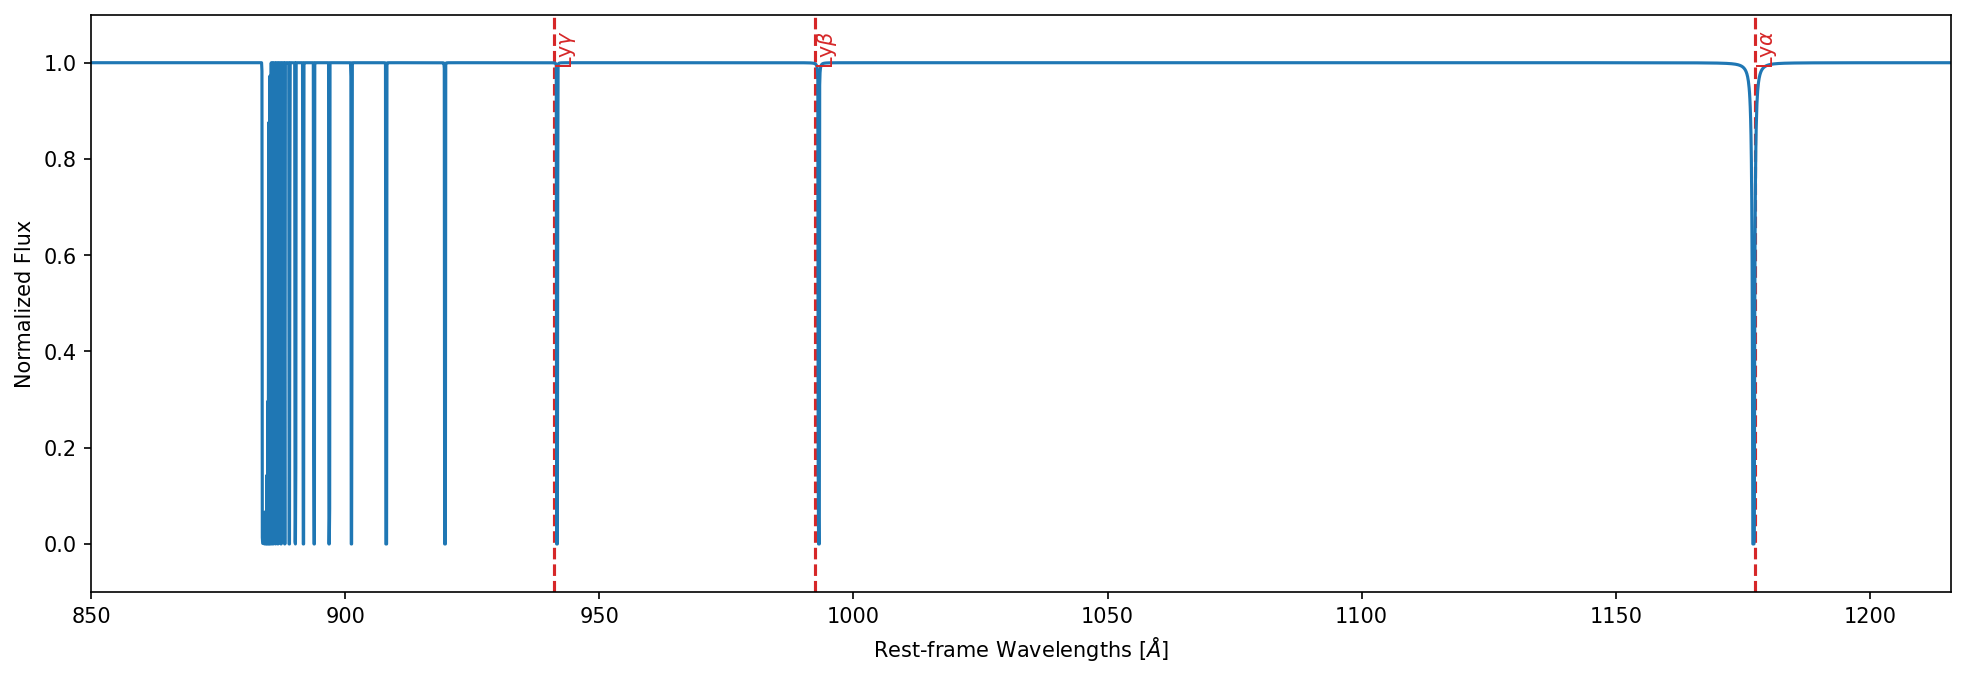

In [15]:
# Assume there's an absorber at redshift 2.9
z_dla = 2.9
nhi   = 10**18 # [cm^-2]

plt.figure(figsize=(16, 5))

voigt_profile = voigt.voigt_absorption(
    np.linspace(850, 1216, num=5000) * (1 + z_qso),
    nhi=nhi,
    z_dla=z_dla,
    num_lines=31,
    broadening=False,
)

plt.vlines(1216 * (1 + z_dla) / (1 + z_qso), -0.1, 1.1, color="C3", ls="--", label=r"Ly$\alpha$")
plt.vlines(1025 * (1 + z_dla) / (1 + z_qso), -0.1, 1.1, color="C3", ls="--", label=r"Ly$\beta$")
plt.vlines(972 * (1 + z_dla) / (1 + z_qso), -0.1, 1.1, color="C3", ls="--", label=r"Ly$\gamma$")
plt.text(1216 * (1 + z_dla) / (1 + z_qso), 1, r"Ly$\alpha$", rotation="vertical", color="C3")
plt.text(1025 * (1 + z_dla) / (1 + z_qso), 1, r"Ly$\beta$", rotation="vertical", color="C3")
plt.text(972 * (1 + z_dla) / (1 + z_qso), 1, r"Ly$\gamma$", rotation="vertical", color="C3")

plt.plot(np.linspace(850, 1216, num=5000), voigt_profile)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-0.1 , 1.1)
plt.xlim(850, 1216)


All of these lines will be the feature we can use to constrain Lyman alpha absorbers.

## Understand how to use Bayesian model selection

Bayesian model selection provides a way to compare the performance of different models in a Bayesian way.
For a good lecture, mathmaticalmonk provides a nice [video](https://youtu.be/1CFof6hU3cI).
In a nutshell, you can think Bayesian model selection as a Bayesian way to do hypothesis testing.

Suppose you have two hypothesis: $M_1$ and $M_2$.
Each model has some capability to explain the data, $\mathcal{D}$.
The probability that $M_1$ can explain the data is $p(\mathcal{D} \mid M_1)$, and vice versa.
This probability, the ability of hypothesis explaining a given data, is also called "likelihood".

However, likelihoods are not the whole story.
We need to consider the fact that the $M_1$ and $M_2$ have different occurrence rates, i.e., one of the hypothesis might be rarer happened than the other one.
For example, the number of people who have cancers is less than people who don't, so the hypothsis of a person having a cancer should be assigned a smaller probability.
When you don't consider the base rate, you might misinterpret the results.
This is often called the [base-rate fallacy](https://en.wikipedia.org/wiki/Base_rate).




In some scientific domains, people claim that a p-value smaller than 0.05 is required to reject the null hypothesis. However, as a Bayesian, we prefer to express the problem in a Bayesian way, which takes into account the effects of the base-rate fallacy.

In Bayesian statistics, we can incorporate the prior probabilities, which are the probabilities of the hypotheses, $p(M)$. The prior probability is essentially the occurrence of the hypothesis or how common it is. With prior probabilities, we can calculate the posterior probability of the hypothesis, which is how likely it is that the hypothesis is true. For example, if $M_1$ is the null hypothesis with a prior probability of $p(M_1) = 0.95$, this means that it occurs more often than the other hypothesis.

The likelihood of $M_2$ needs to be $p(\mathcal{D} \mid M_2) > 0.95$ to make the hypothesis $M_2$ more likely than $M_1$. To calculate the posterior probability of $M_2$, we can use the formula:
$$
p(M_1 \mid \mathcal{D}) = \frac{p(M_1) p(\mathcal{D} \mid M_1)}{ p(M_1) p(\mathcal{D} \mid M_1) + p(M_2) p(\mathcal{D} \mid M_2) }
$$
Note that $p(M_2) = 1 - p(M_1) = 0.05$.

This means that the likelihood of $M_1$ is less than 0.05, which is almost equivalent to saying that the p-value (likelihood in the Bayesian sense) is less than 0.05.

In the following tutorial, we will use Bayesian model selection to find spectra with Lyman alpha absorbers. It is important to note that in Bayesian statistics, models and hypotheses are interchangeable.



We first load the default parameters we had before in the Ho-Bird-Garnett (2020) model:

In [16]:
from gpy_dla_detection.set_parameters import Parameters


In [17]:
# Note: these parameters are used during training. Change these parameters here won't change your
# trained GP model unless you re-train your GP model.
param = Parameters(
    loading_min_lambda = 800,                     # range of rest wavelengths to load  Å
    loading_max_lambda = 1550,
    # normalization parameters
    normalization_min_lambda = 1425,              # range of rest wavelengths to use   Å
    normalization_max_lambda = 1475,              #   for flux normalization
    # null model parameters
    min_lambda         =  850.75,                 # range of rest wavelengths to       Å
    max_lambda         = 1420.75,                 #   model
    dlambda            =    0.25,                 # separation of wavelength grid      Å
    k                  = 20,                      # rank of non-diagonal contribution
    max_noise_variance = 3**2,                    # maximum pixel noise allowed during model training
)

# BOSS DR12 effective optical depth
param.tau_0_mu                  = 0.00554          # meanflux suppression for τ₀
param.tau_0_sigma               = 0.00064          # meanflux suppression for τ₀
param.beta_mu                   =   3.182          # meanflux suppression for β
param.beta_sigma                =   0.074          # meanflux suppression for β

param

{'loading_min_lambda': 800, 'loading_max_lambda': 1550, 'z_qso_cut': 2.15, 'min_num_pixels': 200, 'normalization_min_lambda': 1425, 'normalization_max_lambda': 1475, 'min_lambda': 850.75, 'max_lambda': 1420.75, 'dlambda': 0.25, 'k': 20, 'max_noise_variance': 9, 'initial_c_0': 0.1, 'initial_tau_0': 0.0023, 'initial_beta': 3.65, 'minFunc_options': {'MaxIter': 2000, 'MaxFunEvals': 4000}, 'num_dla_samples': 10000, 'alpha': 0.97, 'uniform_min_log_nhi': 20.0, 'uniform_max_log_nhi': 23.0, 'fit_min_log_nhi': 20.0, 'fit_max_log_nhi': 22.0, 'prior_z_qso_increase': 0.10006922855944561, 'width': 3, 'pixel_spacing': 0.0001, 'num_lines': 3, 'max_z_cut': 0.010006922855944561, 'min_z_cut': 0.010006922855944561, 'num_forest_lines': 31, 'tau_0_mu': 0.00554, 'tau_0_sigma': 0.00064, 'beta_mu': 3.182, 'beta_sigma': 0.074}

These parameters are the parameters we had when we trained the Gaussian process model. Details can be found in `set_parameter.m`.

We also need the prior probabilities of the models:

In [18]:
from gpy_dla_detection.model_priors import PriorCatalog

# Note: you need to follow the README to download these files! 
prior = PriorCatalog(
    param,
    "data/dr12q/processed/catalog.mat",
    "data/dla_catalogs/dr9q_concordance/processed/los_catalog",
    "data/dla_catalogs/dr9q_concordance/processed/dla_catalog",
)


Text(0, 0.5, 'p(DLA | zQSO)')

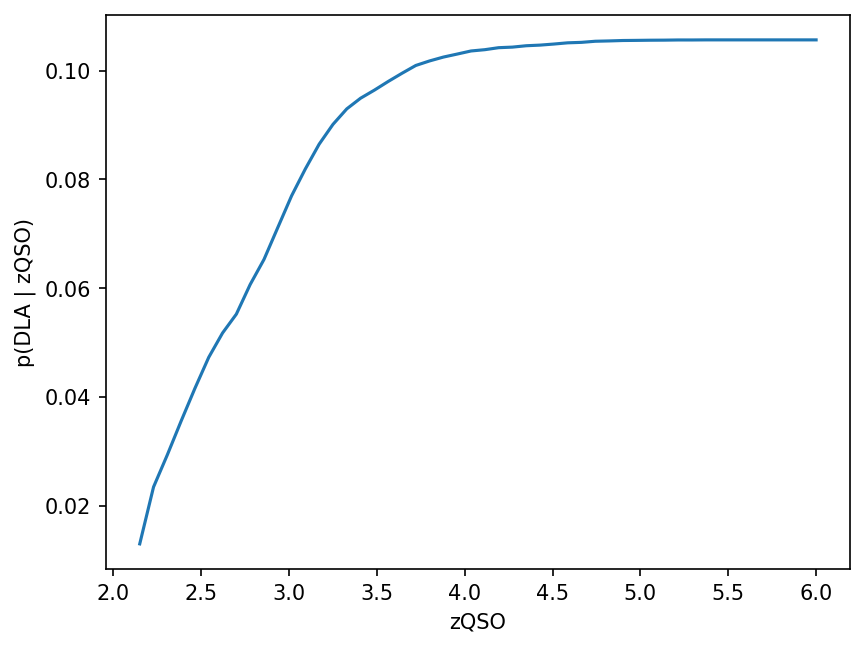

In [19]:
z_qso_list = np.linspace(2.15, 6)

dla_prior = []
for _z in z_qso_list:
    this_num_dlas, this_num_quasars = prior.less_ind(_z)

    # The prior of DLA = number of DLAs at a given redshift / (number of quasar sightlines with and without DLAs)
    _dla_prior = this_num_dlas / this_num_quasars
    dla_prior.append(_dla_prior)

plt.plot(z_qso_list, dla_prior, label="p(DLA | zQSO)")
plt.xlabel("zQSO")

plt.ylabel("p(DLA | zQSO)")

The above plot shows the probability of finding a damped Lyman alpha absorber (DLA) in a quasar spectrum at a given redshift. The plot indicates that it is more likely (~10 percent) to find a DLA at higher redshifts (zQSO > 4).

The prior we used in this analysis is based on visual inspection of damped Lyman alpha absorbers in SDSS DR9. However, since we are considering more general Lyman alpha absorbers with column densities between $\log N_\mathrm{HI} = 17$ and $23$, the prior may be underestimated. We will need to consider modifying the prior in the future works.

Before we proceed, let's define our null model (absence of an absorber) and our absorption model (presence of a Lyman alpha absorber).

### Null Model

In [20]:
from gpy_dla_detection.null_gp import NullGP
from gpy_dla_detection.dla_gp import DLAGP

# Use h5py to read the learned GP model
import h5py 

In [21]:
# Null model GP : a GP model without any DLA intervening.
# Note that it's model without DLAs, so the noise term might still include some
# LLS or subDLAs
class NullGPDR12(NullGP):
    """
    Load learned model from SDSS DR12 data without DLAs
    
    params: globla parameters used to train the model and some parameters define to priors of the model.
    prior: the prior catalog based on SDSS DR9 Lya catalog (We haven't switch to DR12 DLA catalog, we could
        use Ho-Bird-Garnett 2020 catalog). You can change the definition of self.log_prior
        to overwrite the prior from prior catalog.
    learned_file: the input .MAT file for the learned GP model.
    prev_tau_0: tau_0 to change the meanflux of the GP mean function. The effective meanflux model is
        tau = tau_0 * exp( -(1 + z)^beta ). Details see gpy_dla_detection/effective_optical_depth.py
    prev_beta: beta to change the meanflux of thte GP mean function.
    """

    def __init__(
        self,
        params: Parameters,
        prior: PriorCatalog,
        learned_file: str = "learned_qso_model_lyseries_variance_kim_dr9q_minus_concordance.mat",
        prev_tau_0: float = 0.0023,
        prev_beta: float  = 3.65,
    ):
        with h5py.File(learned_file, "r") as learned:

            rest_wavelengths = learned["rest_wavelengths"][:, 0]
            mu = learned["mu"][:, 0]
            M = learned["M"][()].T
            log_omega = learned["log_omega"][:, 0]
            log_c_0 = learned["log_c_0"][0, 0]
            log_tau_0 = learned["log_tau_0"][0, 0]
            log_beta = learned["log_beta"][0, 0]

        super().__init__(
            params,
            prior,
            rest_wavelengths,
            mu,
            M,
            log_omega,
            log_c_0,
            log_tau_0,
            log_beta,
            prev_tau_0=prev_tau_0,
            prev_beta=prev_beta,
        )

In [22]:
# get the instance of GP null model
gp = NullGPDR12(
    params=param,
    prior=prior,
    # you should put your downloaded file in this directory
    learned_file="data/dr12q/processed/learned_qso_model_lyseries_variance_wmu_boss_dr16q_minus_dr12q_gp_851-1421.mat",
    # SDSS/BOSS DR12 meanflux effective optical depth for Lyman alpha forest
    prev_tau_0 = 0.00554,
    prev_beta  = 3.182,
)

# Make the GP model interpolated onto the observed quasar spectum
gp.set_data(
    rest_wavelengths, flux, noise_variance, pixel_mask, z_qso, build_model=True
)

Now we can visualize the mean and covariance functions of the GP null model. Recall that a GP can be fully characterized by its mean function and covariance function, which capture the expected value and variability, respectively, of the function values at different input points

(-1.0, 5.0)

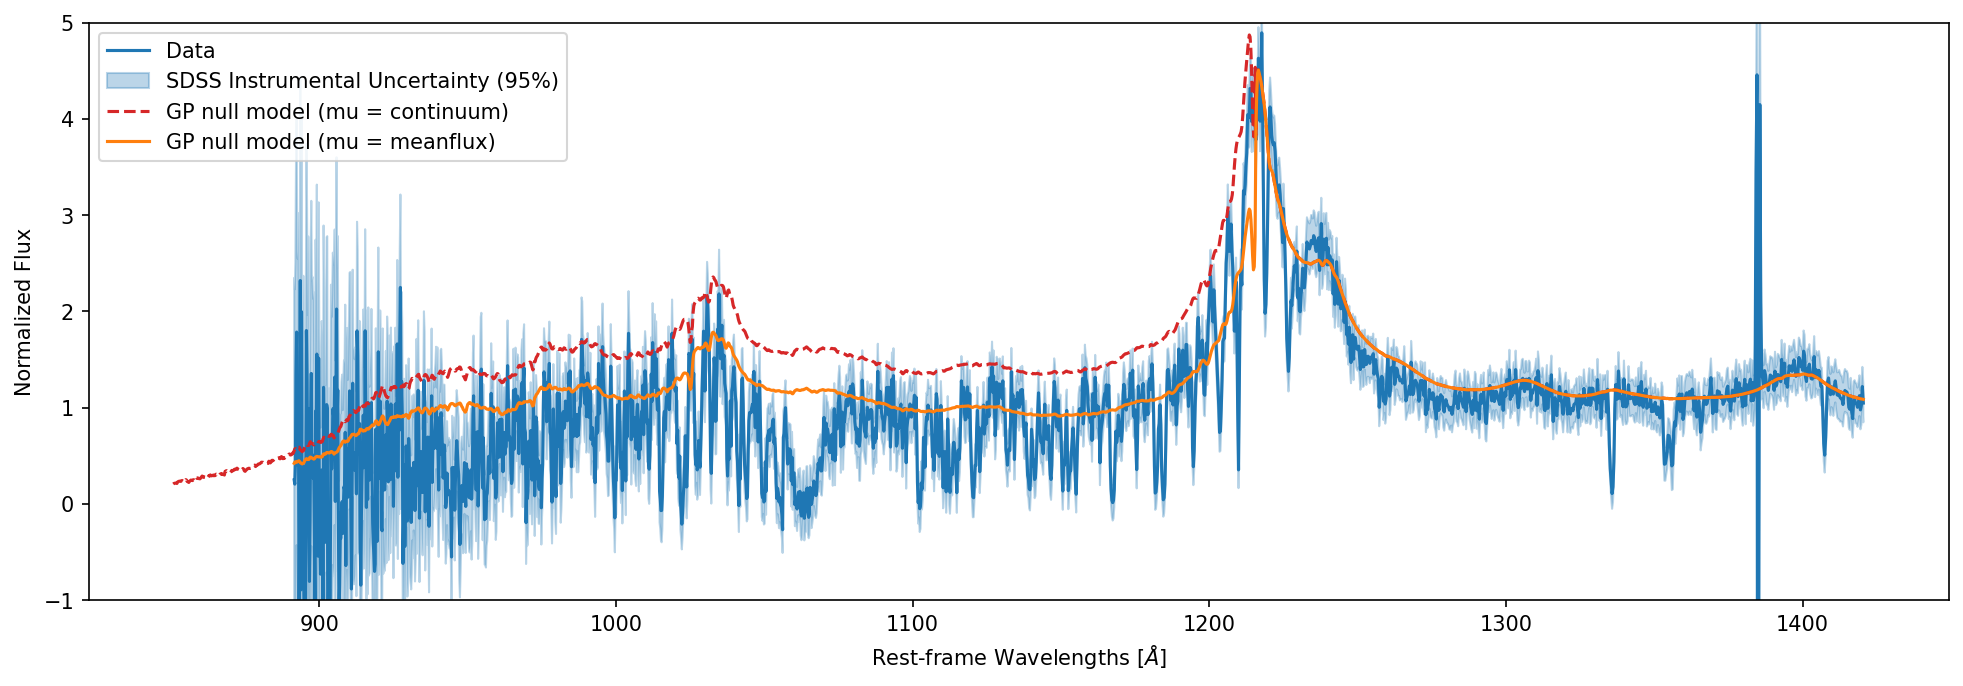

In [23]:
plt.figure(figsize=(16, 5))

# Mean function
plt.plot(
    gp.X, # quasar spectrum's rest-frame wavelengths
    gp.Y, # quasar spectrum's flux
    label="Data",
)
plt.fill_between(
    gp.X,
    gp.Y - 2*np.sqrt(gp.v),
    gp.Y + 2*np.sqrt(gp.v),
    label="SDSS Instrumental Uncertainty (95%)",
    color="C0",
    alpha=0.3,
)
plt.plot(
    gp.rest_wavelengths,
    gp.mu,
    label="GP null model (mu = continuum)",
    color="C3",
    ls="--"
)
plt.plot(
    gp.X,
    gp.this_mu, # GP model's mean function
    label="GP null model (mu = meanflux)"
)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.legend()
plt.ylim(-1, 5)

The above plot shows our GP model, which represents the quasar continuum and meanflux without any significant Lya alpha absorption. To fit the GP mean function to the quasar meanflux, we use the effective optical depth model, which is defined as follows:

$$
\mu = \mu_\mathrm{continuum} \times \exp(-\tau_0 (1 + z)^{\beta})
$$

The effective optical depth describes how the quasar meanflux changes due to the effective absorptions from the Lyman alpha forest. At higher redshifts, the effective absorption will be stronger, resulting in more absorptions.

In addition to the GP model, the observed data is also plotted in blue to illustrate how well the GP model can describe the data. The shaded area indicates the uncertainty intrinsic to the data, which is due to SDSS instrumental uncertainty.


Let's take a closer look at the covariance kernel function of our GP model. This function encodes information about how different emissions in a quasar spectrum are correlated with each other. By examining the kernel, we can gain insights into the underlying physical processes that give rise to the quasar spectra.



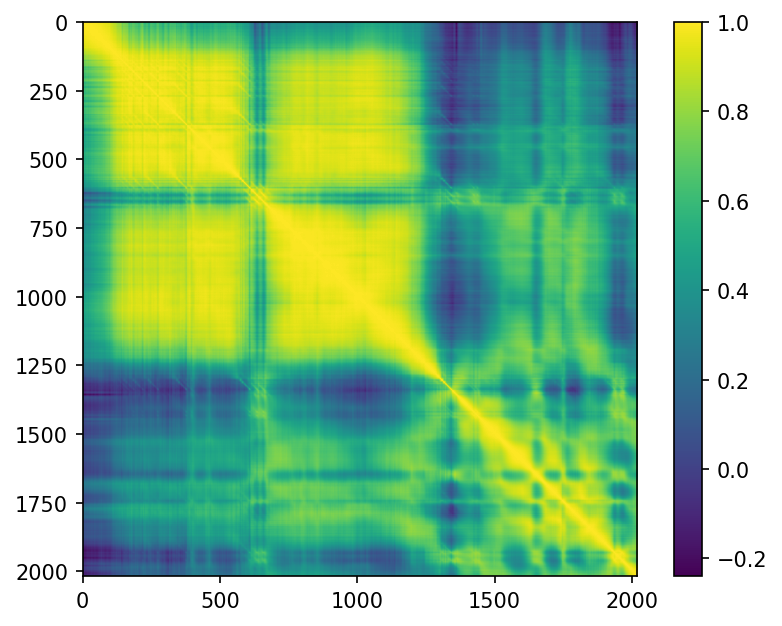

In [24]:
# Covariance kernel function
gp.this_K
# Convert the covariance to correlation. Normalize the diag elements to unity
def build_correlation_matrix(M):
    """
    Covert covariance matrix to correlation matrix
    Parameters:
    ----
    M (N pixels, k) : K = M M' , K is a covariance matrix, M is its matrix decomposition
    Return:
    ----
    C : correlations matrix with its diag C = I
    """
    # build covariance matrix
    K = np.matmul(M, M.T)

    # query diag elements
    d = np.sqrt(np.diag(K))[:, np.newaxis]

    M_div_d = M / d

    C = np.matmul(M_div_d, M_div_d.T)

    return C

C = build_correlation_matrix(gp.this_M)

plt.imshow(C)
plt.colorbar()

### Strong Lyman Alpha Absorber Model (Detection model)

We will now define our model for "detection", which refers to detecting at least one strong Lyman alpha absorber.
Our detection model is simply defined as the null model multiplied with the Voigt profile.

In [25]:
from gpy_dla_detection.dla_gp import DLAGP
from gpy_dla_detection.dla_samples import DLASamplesMAT

In [26]:
# Strong Lyman Alpha model GP : a GP model with at least one strong Lyman alpha absorption.
class LyaGPDR12(DLAGP):
    """
    Load learned model from SDSS DR12 data without DLAs, and parameterize the Voigt profile + include
    the parameter priors (NHI, zLya) for sampling the Voigt profile

    Parameters:
    ---
    lya_samples: the Monte Carlo samples of the prior (NHI, zLya) you will be using to search for the
        strong Lya absorbers.

    params: globla parameters used to train the model and some parameters define to priors of the model.
    prior: the prior catalog based on SDSS DR9 Lya catalog. You can change the definition of self.log_prior
        to overwrite the prior from prior catalog.
    learned_file: the input .MAT file for the learned GP model.
    prev_tau_0: tau_0 to change the meanflux of the GP mean function. The effective meanflux model is
        tau = tau_0 * exp( -(1 + z)^beta ). Details see gpy_dla_detection/effective_optical_depth.py
    prev_beta: beta to change the meanflux of thte GP mean function.
    """

    def __init__(
        self,
        params: Parameters,
        prior: PriorCatalog,
        lya_samples: DLASamplesMAT,
        learned_file: str = "learned_qso_model_lyseries_variance_kim_dr9q_minus_concordance.mat",
        prev_tau_0: float = 0.0023,
        prev_beta: float  = 3.65,
        min_z_separation: float = 3000.0, # km/s
        broadening: bool = True,
    ):
        with h5py.File(learned_file, "r") as learned:

            rest_wavelengths = learned["rest_wavelengths"][:, 0]
            mu = learned["mu"][:, 0]
            M = learned["M"][()].T
            log_omega = learned["log_omega"][:, 0]
            log_c_0 = learned["log_c_0"][0, 0]
            log_tau_0 = learned["log_tau_0"][0, 0]
            log_beta = learned["log_beta"][0, 0]

        super().__init__(
            params,
            prior,
            lya_samples,
            rest_wavelengths,
            mu,
            M,
            log_omega,
            log_c_0,
            log_tau_0,
            log_beta,
            prev_tau_0=prev_tau_0,
            prev_beta=prev_beta,
            min_z_separation=min_z_separation,
            broadening=broadening,
        )

To search for Lyman alpha absorbers with column densities in the range of log NHI = 17-23, including both DLAs and LLSs, we need to specify a prior for the parameters (zLya, NHI) in our detection model. However, currently, we only have a prior for DLA parameters, which covers the range of log NHI = 20-23.

As an initial guess, we assume a flat prior for log NHI = 17-20. We will need to modify the prior later based on the column density distribution function at the population level. To do this, we will use the NHI distribution from Garnett 2017 and add a flat prior for the low-column density region.

Sum of the PDF:


1.0007862944718966

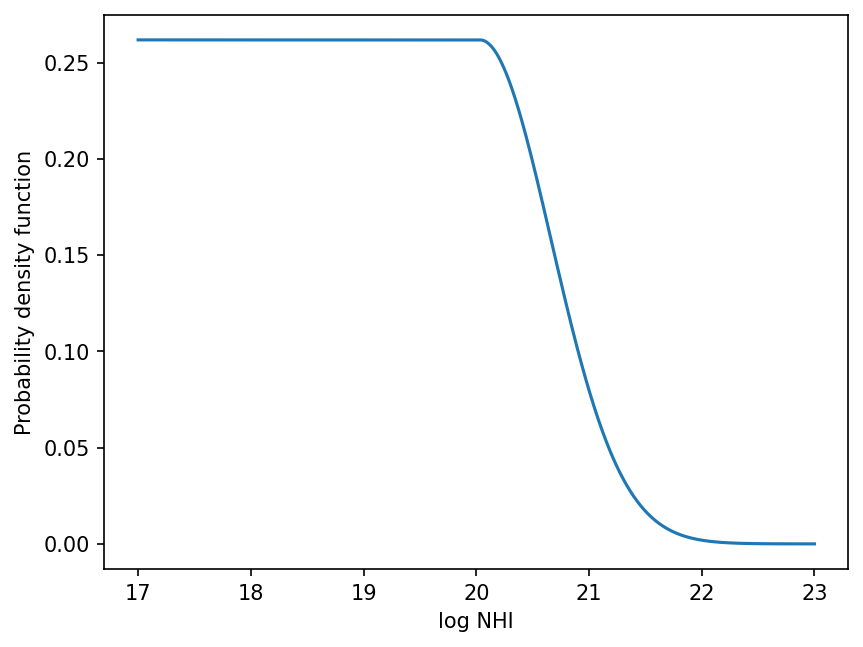

In [27]:
from scipy.integrate import quad # to get the normalization constant for the probability density function

# directly use the fitted poly values in the Garnett (2017)
unnormalized_dla_pdf = lambda log_nhi: (np.exp(
    -1.2695 * log_nhi**2 + 50.863 * log_nhi -509.33
    )
)
# add a flat prior at the low column density end
unnormalized_pdf = lambda log_nhi : (
    unnormalized_dla_pdf(log_nhi) * (log_nhi >= 20.03) +
    unnormalized_dla_pdf(20.03)      * (log_nhi <  20.03)
)

Z = quad(unnormalized_pdf, 17, 23.0)[0]

normalized_pdf = lambda log_nhi : unnormalized_pdf(log_nhi) / Z


log_nhis = np.linspace(17, 23, num=1000)
plt.plot(log_nhis, normalized_pdf(log_nhis))
plt.xlabel("log NHI")
plt.ylabel("Probability density function")

# Make sure the probability density is summed to one
print("Sum of the PDF:")
np.sum(normalized_pdf(log_nhis) * (log_nhis[1] - log_nhis[0]))

In [28]:
# We want Monte Carlo samples - here to use Halton sequence to speed up the convergence
from scipy.stats.qmc import Halton
from scipy.interpolate import interp1d

sampler = Halton(
    d=2, # dimension of parameter space
    scramble=True,
)

In [29]:
num_samples = 10000
halton_sequence = sampler.random(num_samples)

# Inver transform sampling
# https://en.wikipedia.org/wiki/Inverse_transform_sampling
# code ref:
# https://gist.github.com/amarvutha/c2a3ea9d42d238551c694480019a6ce1
def sample(g, min_lognhi = 17, max_lognhi = 23):
    x = np.linspace(
        min_lognhi,
        max_lognhi,
        num=int(1e8),               # if you see interpolation error, increase this number 
    )
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interp1d(cdf_y, x)    # this is a function
    return inverse_cdf

def return_samples(halton_sequence: np.ndarray):
    required_samples = sample(
        normalized_pdf
    )(halton_sequence)
    return required_samples

samples_log_nhis = return_samples(halton_sequence[:, 0], )

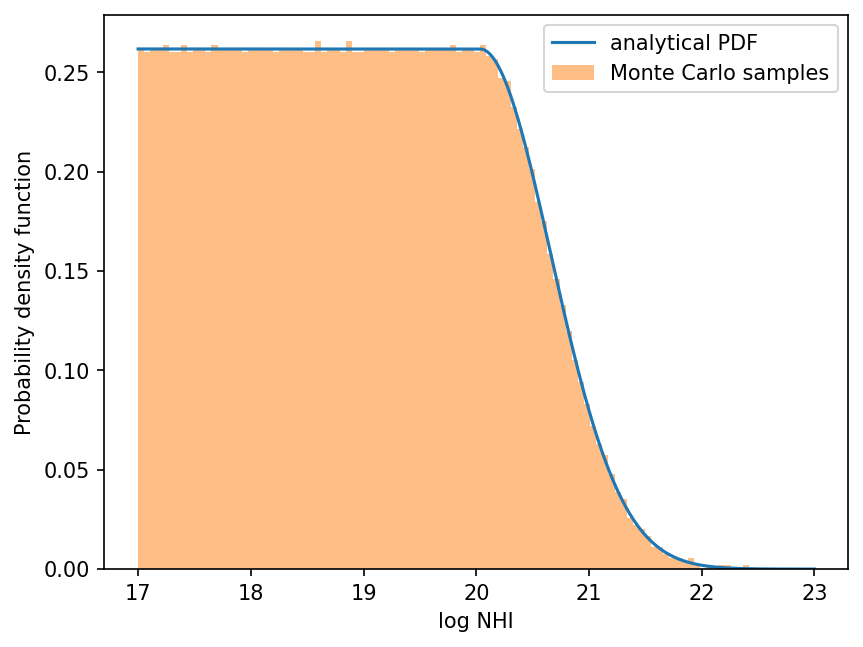

In [30]:
plt.plot(log_nhis, normalized_pdf(log_nhis), label="analytical PDF")
plt.xlabel("log NHI")
plt.ylabel("Probability density function")
plt.hist(samples_log_nhis, bins=100, density=True, alpha=0.5, label="Monte Carlo samples")

plt.legend()

We assume a uniform prior for the redshift of strong Lyman alpha absorbers, with the following limits:


$$
z_\mathrm{Ly\alpha} \sim \mathrm{Uniform}(z_\mathrm{min}, z_\mathrm{max}),
$$
where
$$
z_\mathrm{min}  = z_\mathrm{Ly\infty} + 3000 \mathrm{km/s}
$$
and
$$
z_\mathrm{max}  = z_\mathrm{QSO} - 3000 \mathrm{km/s}.
$$

* $z_\mathrm{Ly\infty}$: redshift of the Lyman limit at 911 $\AA$
* $z_\mathrm{QSO}$: redshift of the quasar.

Now we define the Monte Carlo samples for the prior of strong Lya absorber.

We will use 10000 samples to approximate the prior distribution. These samples will be used to marginalize over the (NHI, zLya) parameters and obtain the evidence of strong Lya absorber.

In [31]:
from gpy_dla_detection.dla_samples import DLASamples

In [32]:
class LyaSamples(DLASamples):
    """
    Parameter prior (NHI, zLya) for strong Lya absorbers (logNHI = 17 - 23).

    This is a wrapper over the Monte Carlo samples already generated, so
    you should have already obtained the samples for the parameter prior
    somewhere else.

    We assume the same zLya prior as Garnett (2017):

        zLya ~ U(zmin, zmax)

        zmax = z_QSO - max_z_cut
        zmin = z_Ly∞ + min_z_cut
    """

    def __init__(
        self,
        params: Parameters,
        prior: PriorCatalog,
        offset_samples: np.ndarray,
        log_nhi_samples: np.ndarray,
        max_z_cut: float = 3000, # km/s
        min_z_cut: float = 3000, # km/s
    ):
        super().__init__(params, prior)

        self._offset_samples = offset_samples
        self._log_nhi_samples = log_nhi_samples
        self._nhi_samples = 10**log_nhi_samples

    @property
    def offset_samples(self) -> np.ndarray:
        return self._offset_samples

    @property
    def log_nhi_samples(self) -> np.ndarray:
        return self._log_nhi_samples

    @property
    def nhi_samples(self) -> np.ndarray:
        return self._nhi_samples

    def sample_z_dlas(self, wavelengths: np.ndarray, z_qso: float) -> np.ndarray:
        sample_z_dlas = (
            self.params.min_z_dla(wavelengths, z_qso)
            + (
                self.params.max_z_dla(wavelengths, z_qso)
                - self.params.min_z_dla(wavelengths, z_qso)
            )
            * self._offset_samples
        )

        return sample_z_dlas

    def _build_pdf(self):
        """
        Benchmark PDF we used in Garnett (2017), without mixing with a uniform prior
        """
        # directly use the fitted poly values in the Garnett (2017)
        unnormalized_dla_pdf = lambda log_nhi: (np.exp(
            -1.2695 * log_nhi**2 + 50.863 * log_nhi -509.33
            )
        )
        # add a flat prior at the low column density end
        unnormalized_pdf = lambda log_nhi : (
            unnormalized_dla_pdf(log_nhi) * (log_nhi >= 20.03) +
            unnormalized_dla_pdf(20.03)      * (log_nhi <  20.03)
        )

        Z = quad(unnormalized_pdf, 17, 23.0)[0]

        self.normalized_pdf = lambda log_nhi : unnormalized_pdf(log_nhi) / Z


    def pdf(self, log_nhi: float) -> float:
        """
        The logNHI pdf used in Garnett (2017) paper.
        """
        return self.normalized_pdf(log_nhi)

In [33]:
lya_samples = LyaSamples(
    params=param,
    prior=prior,
    # offset samples
    offset_samples  = halton_sequence[:, 1],
    log_nhi_samples = samples_log_nhis,
    max_z_cut=3000,
    min_z_cut=3000,
)

In [34]:
# Lya Model GP : this is null model GP + Voigt profile, which is parameterised with
# {(z_lya, logNHI)}_{i=1}^{k} parameters. k stands for maximum Lya absorpbers we want to search.
# we will compute log posteriors for DLA(1), ..., DLA(k) models.

# I want the Voigt profile to use Lya series lines up to 31
param.num_lines       = 31
param.num_dla_samples = len(samples_log_nhis)

lya_gp = LyaGPDR12(
    params=param,
    prior=prior,
    lya_samples=lya_samples,
    min_z_separation=3000.0,
    learned_file="data/dr12q/processed/learned_qso_model_lyseries_variance_wmu_boss_dr16q_minus_dr12q_gp_851-1421.mat",
    broadening=True,
)
lya_gp.set_data(
    rest_wavelengths, flux, noise_variance, pixel_mask, z_qso, build_model=True,
)

(-1.0, 5.0)

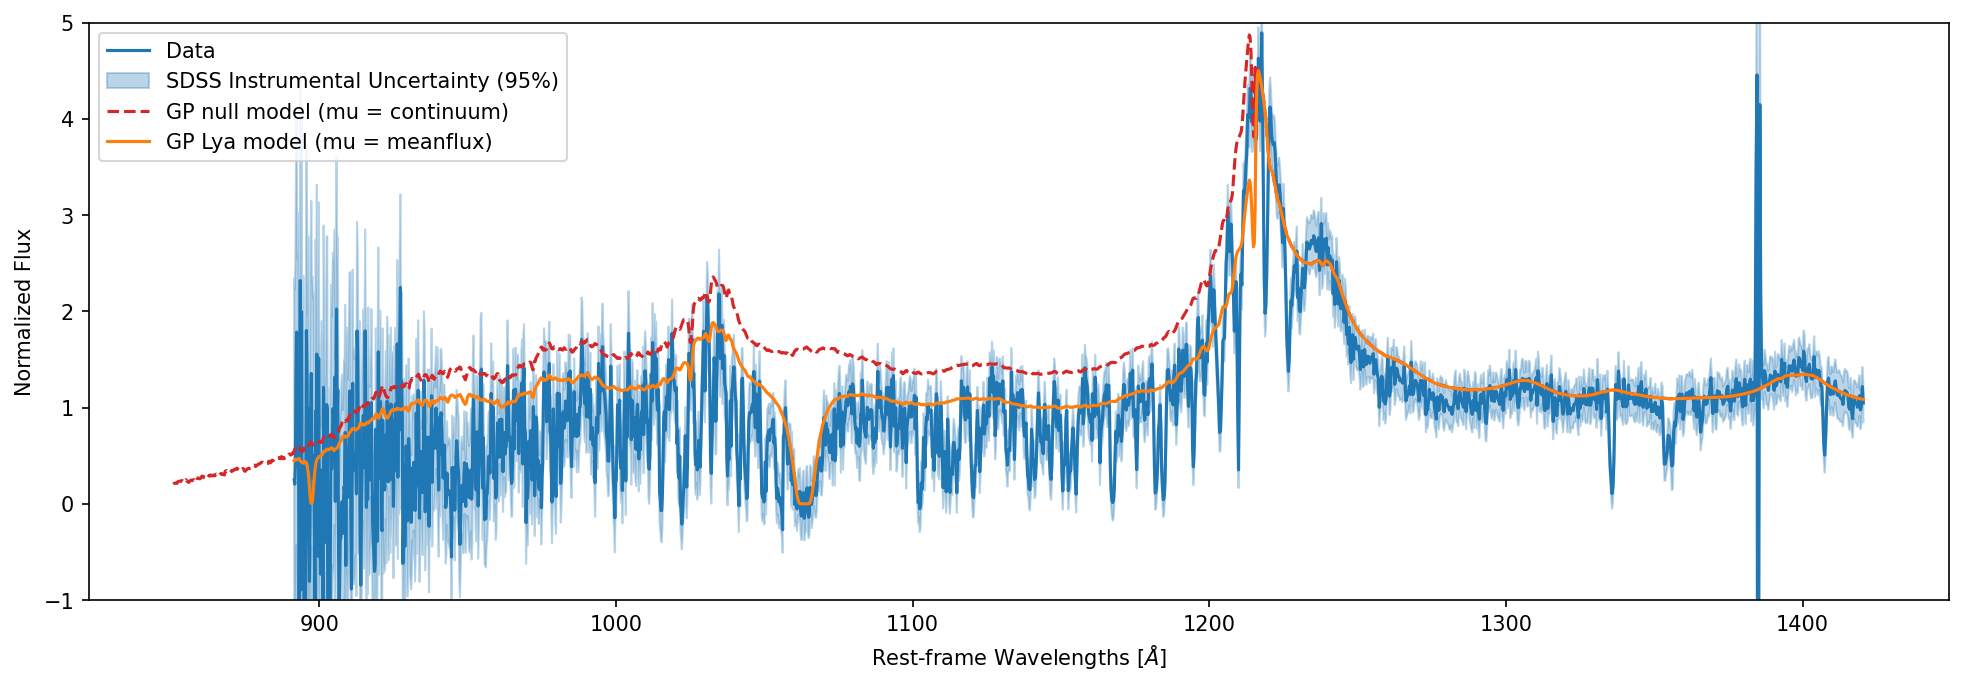

In [35]:
# Now you can get the model with Lya absorbers
z_lya = 2.52372765 #z_qso * 0.9 # an arbitrary number below zQSO
nhi   = 10**20.71157537

lya_mu, lya_M, lya_omega2 = lya_gp.this_dla_gp([z_lya], [nhi])

plt.figure(figsize=(16, 5))

# Mean function
plt.plot(
    gp.X, # quasar spectrum's rest-frame wavelengths
    gp.Y, # quasar spectrum's flux
    label="Data",
)
plt.fill_between(
    gp.X,
    gp.Y - 2*np.sqrt(gp.v),
    gp.Y + 2*np.sqrt(gp.v),
    label="SDSS Instrumental Uncertainty (95%)",
    color="C0",
    alpha=0.3,
)
plt.plot(
    gp.rest_wavelengths,
    gp.mu,
    label="GP null model (mu = continuum)",
    color="C3",
    ls="--"
)
plt.plot(
    gp.X,
    lya_mu, # GP model's mean function
    label="GP Lya model (mu = meanflux)"
)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.legend()
plt.ylim(-1, 5)

In [36]:
# Monte Carlo samples for the prior of absorber redshifts
sample_z_dlas = lya_gp.dla_samples.sample_z_dlas(
        lya_gp.this_wavelengths, lya_gp.z_qso
)

### Marginalize over NHI, zLya

Now we perform the integration for getting the model evidence of strong Lyman alpha absorbers:

$$
p(D \mid \mathcal{M}_\mathrm{Lya}) = \int p(\theta \mid \mathcal{M}_\mathrm{Lya}) p(D \mid \mathcal{M}_\mathrm{Lya}, \theta) \mathrm{d}\theta
$$

This is approximated by Monte Carlo integration:

$$
p(D \mid \mathcal{M}_\mathrm{Lya}) \simeq \frac{1}{N} \sum_{i = 1}^N  p(D \mid \mathcal{M}_\mathrm{Lya}, \theta) \mathrm{d}\theta \\ 
\theta \sim p(\theta \mid \mathcal{M}_\mathrm{Lya}),
$$
where $\theta = (N_\mathrm{HI}, z_\mathrm{Lya})$.

The $\sim$ notation here means $\theta$ is sampled from this $p(\theta \mid \mathcal{M}_\mathrm{Lya})$ distribution.
$N$ means the number of Monte Carlo samples.




In [37]:
import time

In [38]:
# search up to 5 strong Lya absorbers
max_Lya = 5

tt = time.time()
log_likelihoods_lya = lya_gp.log_model_evidences(max_Lya)

print("Spend {:.4g} seconds".format(time.time() - tt))

Spend 256.9 seconds


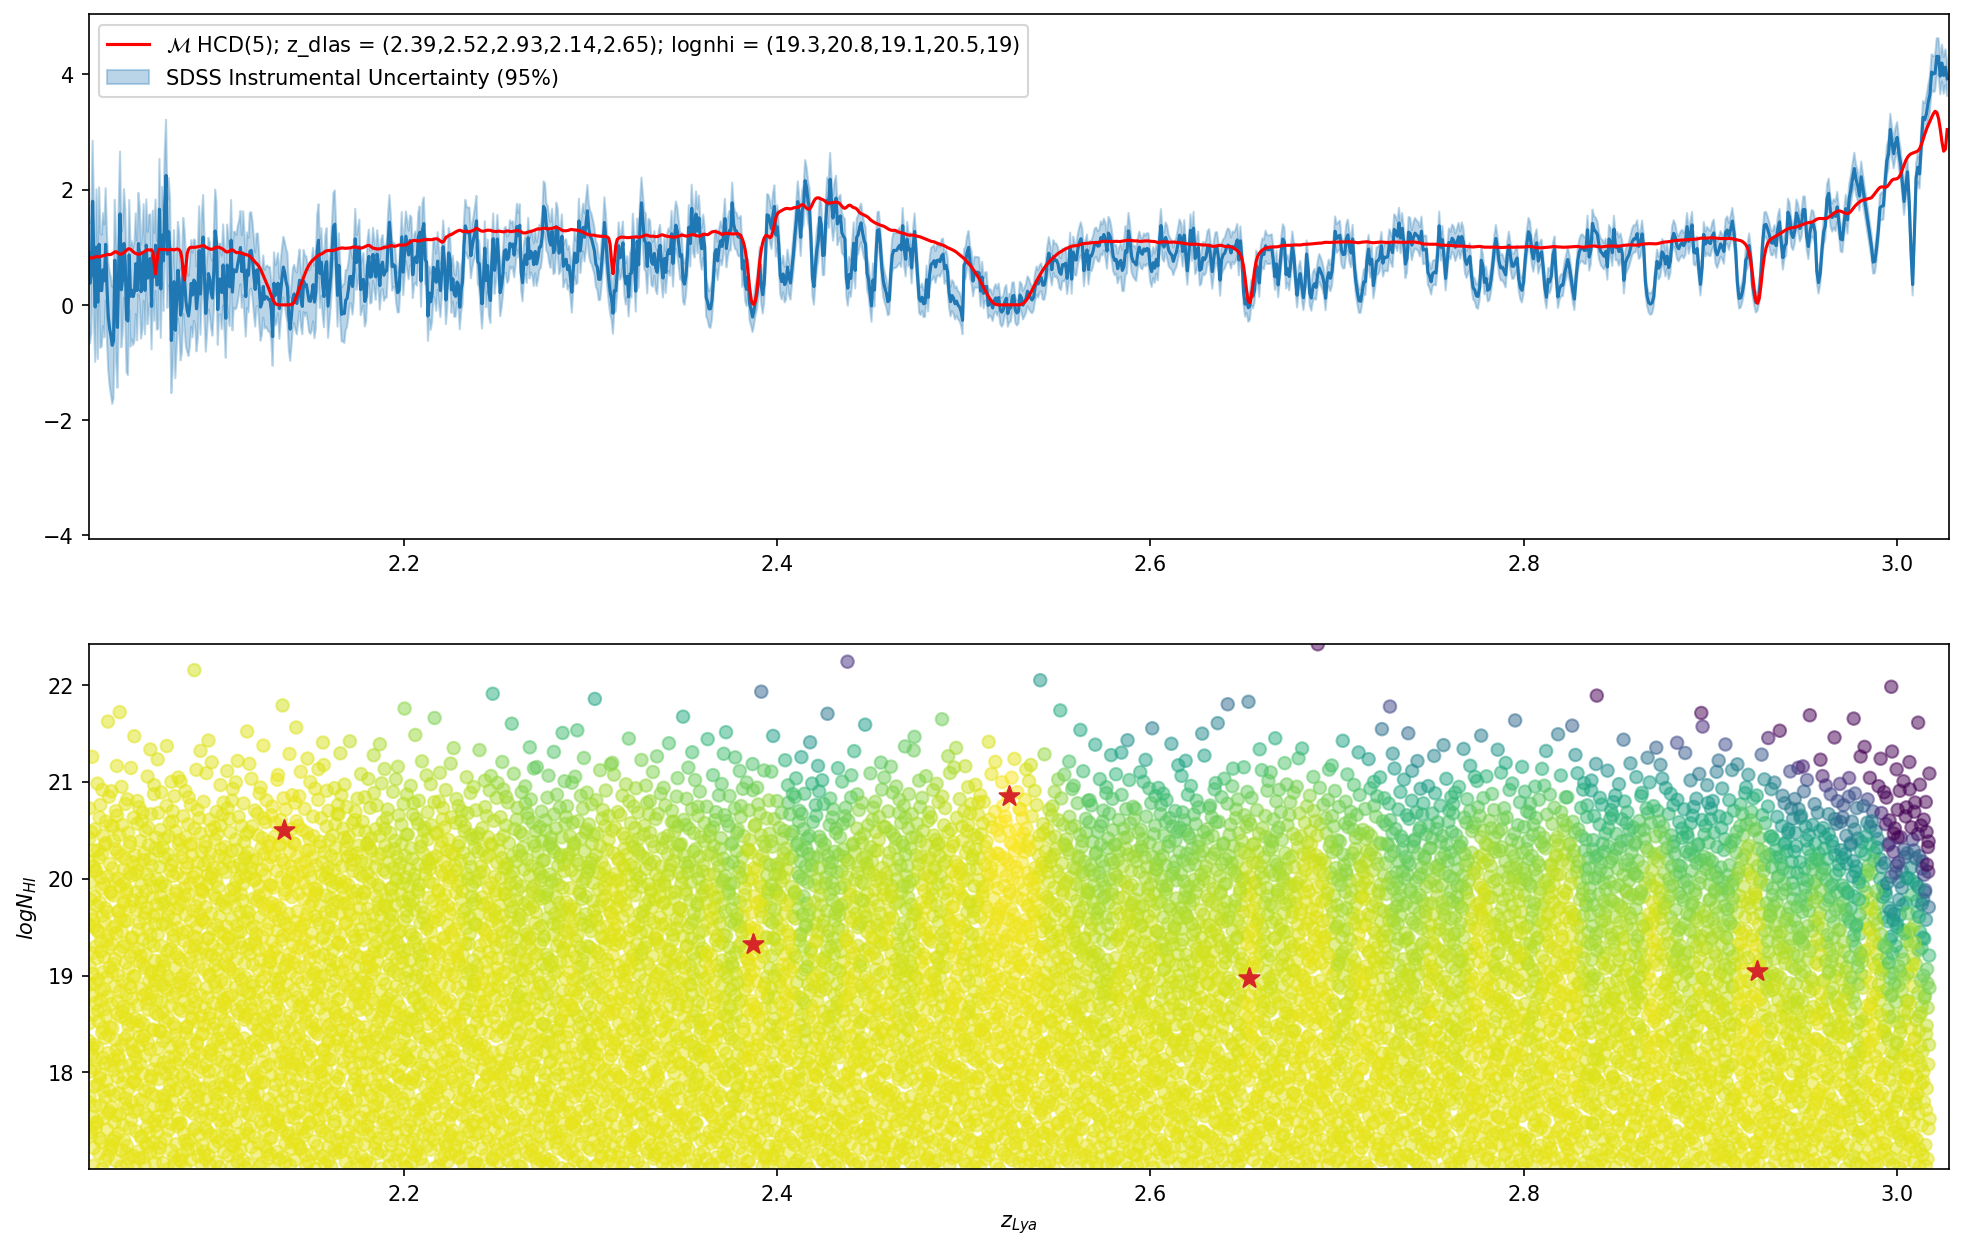

In [39]:
# How many absorbers searches you want to plot
nth_lya = max_Lya # here we plot all of the searches

sample_z_dlas = lya_gp.dla_samples.sample_z_dlas(
        lya_gp.this_wavelengths, lya_gp.z_qso
)

# [color sequence] convert sample log likelihoods to values in (0, 1)
sample_log_likelihoods = lya_gp.sample_log_likelihoods[
    :, 0
]  # only query the DLA(1) likelihoods
# TODO: marginalize over k DLAs
max_like = np.nanmax(sample_log_likelihoods)
min_like = np.nanmin(sample_log_likelihoods)

colours = (sample_log_likelihoods - min_like) / (max_like - min_like)

# scale to make the colour more visible
# TODO: make it more reasonable. scatter only takes values between [0, 1].
colours = colours * 5 - 4
colours[colours < 0] = 0


# Canvas with two panels
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

# 1. Real spectrum space
# N * (1~k models) * (1~k MAP dlas)
MAP_z_dla, MAP_log_nhi = lya_gp.maximum_a_posteriori()
# make them to be 1-D array
map_z_dlas = MAP_z_dla[nth_lya - 1, :nth_lya]
map_log_nhis = MAP_log_nhi[nth_lya - 1, :nth_lya]
# feed in MAP values and get the absorption profile given (z_dlas, nhis)
lya_mu, lya_M, lya_omega2 = lya_gp.this_dla_gp(map_z_dlas, 10 ** map_log_nhis)

# Only plot the spectrum within the search range
this_rest_wavelengths = lya_gp.x
ind = (this_rest_wavelengths < lya_gp.params.lya_wavelength)

this_rest_wavelengths = this_rest_wavelengths[ind]
lya_mu = lya_mu[ind]

ax[0].plot(
    (this_rest_wavelengths * (1 + z_qso)) / lya_gp.params.lya_wavelength - 1,
    lya_gp.Y[ind]
)
ax[0].plot(
    (this_rest_wavelengths * (1 + z_qso)) / lya_gp.params.lya_wavelength - 1,
    lya_mu,
    label=r"$\mathcal{M}$"
    + r" HCD({n}); ".format(n=nth_lya)
    + "z_dlas = ({}); ".format(",".join("{:.3g}".format(z) for z in map_z_dlas))
    + "lognhi = ({})".format(
        ",".join("{:.3g}".format(n) for n in map_log_nhis)
    ),
    color="red",
)
ax[0].fill_between(
    (this_rest_wavelengths * (1 + z_qso)) / lya_gp.params.lya_wavelength - 1,
    gp.Y[ind] - 2*np.sqrt(gp.v[ind]),
    gp.Y[ind] + 2*np.sqrt(gp.v[ind]),
    label="SDSS Instrumental Uncertainty (95%)",
    color="C0",
    alpha=0.3,
)


# 2. Posterior space
ax[1].scatter(
    sample_z_dlas, lya_gp.dla_samples.log_nhi_samples, c=colours,
    marker="o", alpha=0.5,
)
# MAP estimate
ax[1].scatter(
    map_z_dlas, map_log_nhis,
    marker="*",
    s=100,
    color="C3",
)

# [min max sample zDLAs] instead of using min max from sample_z_dlas
# using the zDLAs converted from wavelengths will better reflect the
# range of wavelengths range in the this_mu plot.
ax[1].set_xlim(sample_z_dlas.min(), z_qso)
ax[1].set_ylim(
    lya_gp.dla_samples.log_nhi_samples.min(),
    lya_gp.dla_samples.log_nhi_samples.max(),
)
ax[1].set_xlabel(r"$z_{Lya}$")
ax[1].set_ylabel(r"$log N_{HI}$")

# You want the first panel has the same range
ax[0].set_xlim(sample_z_dlas.min(), z_qso)
ax[0].legend()

### Bayesian model selection

Now that we have the likelihood for how well the absorption model (Lya model) can describe the data (quasar spectrum), we need to establish priors for both the Lya model and the null model.

Our prior for the Lya model is data-driven, which means we obtain it from the previous catalog and define it as follows:
$$Lya
p(\mathcal{M}_\mathrm{Lya} \mid z_\mathrm{QSO}) = \frac{M}{N},
$$
where $M$ is the number of quasar spectra with damped Lyman alpha absorbers and $N$ is the total number of quasar spectra below $z_\mathrm{QSO} + 30,000 ,\mathrm{km/s}$.

However, we are not only searching for DLAs, but also for LLSs, so this prior might not be the most ideal one.

In [40]:
# Log prior probabilities for the absorption model
lya_gp.log_priors(z_qso, max_Lya)

array([ -2.63540823,  -5.18989708,  -7.74438594, -10.29887479,
       -12.77244427])

The numbers above represent the log probabilities for the Lya absorption prior. This prior represents the probability that a Lya absorption is present in the spectrum, before taking into account the information contained in the specific data. It is essentially a belief about the frequency of Lya absorptions in quasar spectra.


In [41]:
# Compute the log of the sum of exponentials of input elements
# This function provides a stable way to compute log(exp(x) + exp(y))
from scipy.special import logsumexp

In [42]:
logsumexp(
    np.append(
        gp.log_prior(z_qso),
        lya_gp.log_priors(z_qso, max_Lya)
    )
)

-2.498001805406602e-16

The sum of the probabilities should be closer to 1, that is, the log of the probability should be closer to 0.

In [43]:
lya_gp.log_model_evidence()

-890.923517337749

In [44]:
# Model posteriors
log_posteriors_lya = log_likelihoods_lya + lya_gp.log_priors(z_qso, max_Lya)
log_posterior_null = gp.log_model_evidence() + gp.log_prior(z_qso)

log_posteriors = np.append(log_posterior_null, log_posteriors_lya)

max_log_posterior = log_posteriors.max()

model_posteriors  = np.exp(log_posteriors - max_log_posterior)
model_posteriors  = model_posteriors / model_posteriors.sum()

model_posteriors

array([7.41593095e-60, 1.13425925e-18, 3.02898732e-11, 4.36381737e-05,
       5.30407110e-02, 9.46915651e-01])

## Things to improve

In this tutorial, we briefly explain how to use Ho-Bird-Garnett (2020) DLA finder and how to extend it to low column density absorbers. The performance of the LLS and SLLS detection are not perfect. Some efforts to improve the model are needed to make the code works better for these absorbers weaker than DLAs.

Some proposed ideas are below:

### Improvements on the science part

* Change the log NHI prior, p(log NHI), to be more realistic than just a flat prior.
* `min_z_separation`: the min separation of the absorbers, maybe we can marginalize over the min separation to make sure we don't lose any neighbor absorbers.
* Write a simulated quasar spectrum script by sampling the spectrum from the GP and
    * inject the Lyman absorbers using Voigt profiles
    * vary the signal-to-noise of the spectrum by adding variance to the simulated spectrum.


### Improvements on the technical part

* Make the Voigt profile computation faster, `gpy_dla_detection/voigt.py`
    * We can make it written C
    * Approximate the higher-order Lyman series lines in the `voigt.py` by a drop (or step function)
    * We can re-write everything in tensorflow (take more time to do it)
* Our GP kernel is trained with quasar spectra without DLAs, so the noise model we have in the GP includes the LLSs. Thus, the noise variance in the GP kernel is higher than the perfect noise model.
    * We can marginalize over the noise variance as a free parameter to overcome this uncertainty.
    * Or, we can iteratively train the GP model by improving the purity of the training set by removing the spectra giving high likelihoods of having LLS or SLLS.
